In [9]:
%matplotlib notebook
import xpcs
import numpy as np
import matplotlib.pyplot as plt

scan = 7555
#scan = 8238
downsample = 1
center_x, center_y = 1069.5, 201.5
rois = [(16+i*1, 16+(i+1)*1) for i in range(9)] # 6X6 binning
rois = [(100, 110)]
#rois = [(90//4+i*3, 90//4+(i+1)*3) for i in range(4)] # 4X4 binning
#rois = [(50+i*5, 50+(i+1)*5) for i in range(6)]
print(rois)
roi_img = xpcs.make_roi(center_x, center_y, rois, downsample)
frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scan, 
                     1.0e-2, roi_img, downsample)

[(100, 110)]


<IPython.core.display.Javascript object>


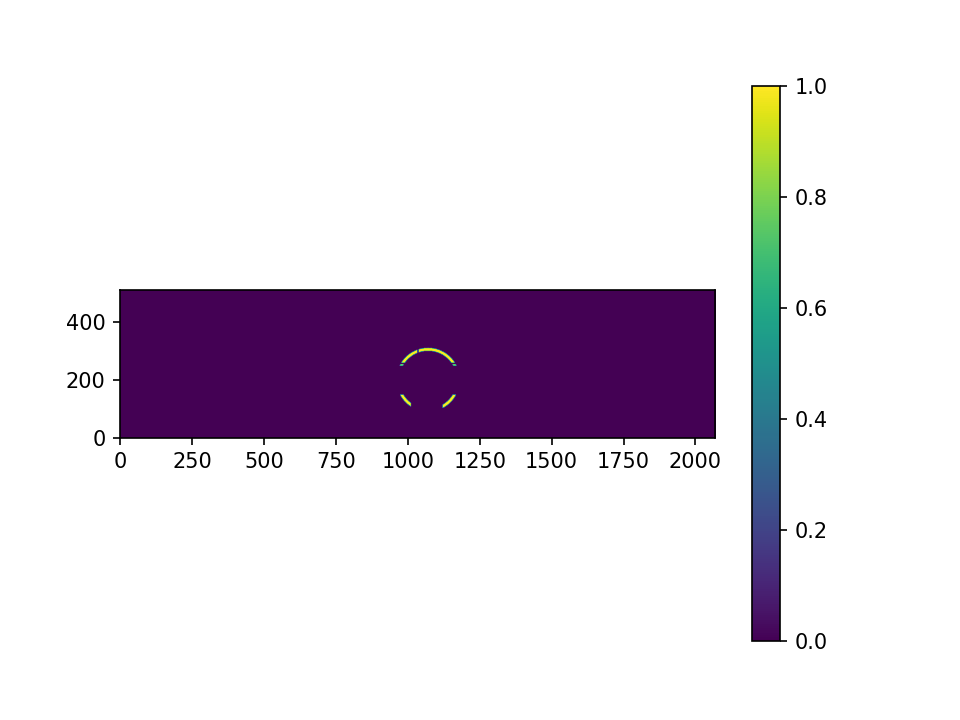

<IPython.core.display.Javascript object>


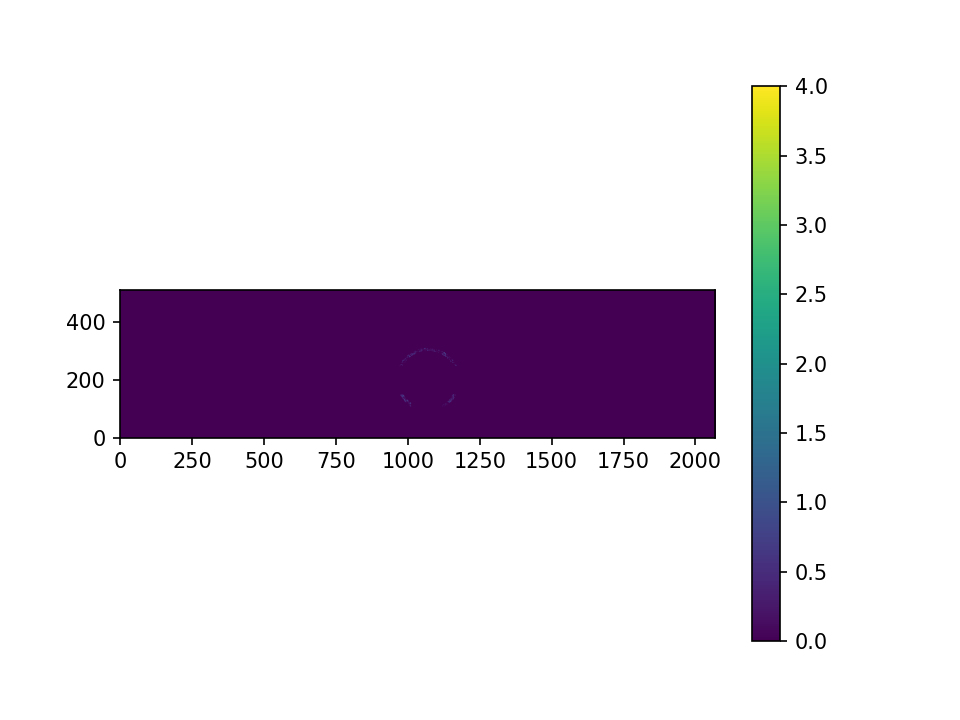

In [20]:
plt.figure()
plt.imshow(roi_img, origin='lower')
plt.colorbar()
#np.unique(roi_img, return_counts=True)

img = xpcs.make_img(frames[0])   
plt.figure()
plt.imshow(img, origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


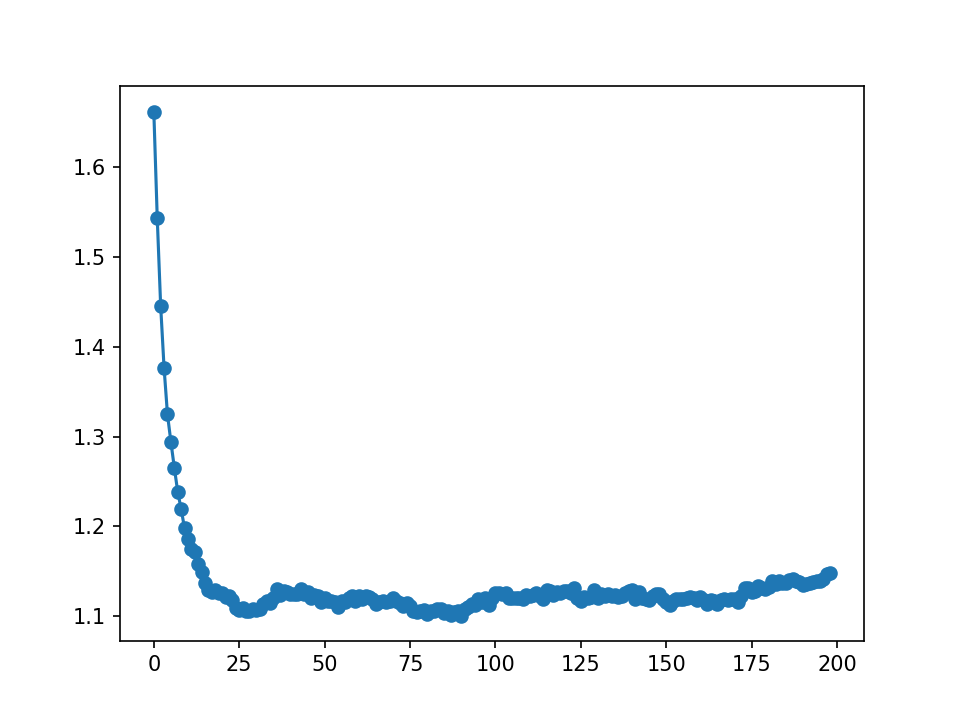

In [19]:
g2 = xpcs.calc_g2(frames, roi_img, range(1, 200))
plt.figure()
for i in range(g2.shape[1]):
    plt.plot(g2[:, i], '-o',  label=str(i))
#plt.xscale('log')

# Multiple scans 

In [11]:
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool

scans = range(7637, 8137)
exp_time = 2.0e-5
downsample = 6
center_x, center_y = 1069.5, 201.5
rois = [(16+i*1, 16+(i+1)*1) for i in range(7)]
print(rois)
roi_img = xpcs.make_roi(center_x, center_y, rois, downsample)

pbar = tqdm(total=len(scans))

def worker(arg, roi_img, exp_time, downsample):
    i, scan = arg
    frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scan, 
                         exp_time, roi_img, downsample)
    return xpcs.calc_g2(frames, roi_img, range(1, 200))
    pbar.update(i)

pool = Pool(32)
g2 = pool.map(partial(worker, roi_img=roi_img, exp_time=exp_time, downsample=downsample), enumerate(scans))
g2 = np.mean(g2, axis=0)

  0%|          | 0/500 [00:00<?, ?it/s]

[(16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23)]


  0%|          | 0/100 [55:37<?, ?it/s]


In [15]:
distance = 4.0 # m
photon_energy = 10.0e3 #eV

h = 4.135667516e-15
c = 2.99792458e8
wavelength = h*c / photon_energy

rs = [0.5*(roi[0]+roi[1])*downsample*55e-6 for roi in rois]
tth = np.arctan2(rs, distance)
q = 4.0e-10 * np.pi / wavelength * np.sin(0.5*tth)
print('wavelength', wavelength)
q

wavelength 1.2398419300923943e-10


array([0.00656995, 0.00696813, 0.0073663 , 0.00776448, 0.00816266,
       0.00856084, 0.00895901])

<IPython.core.display.Javascript object>


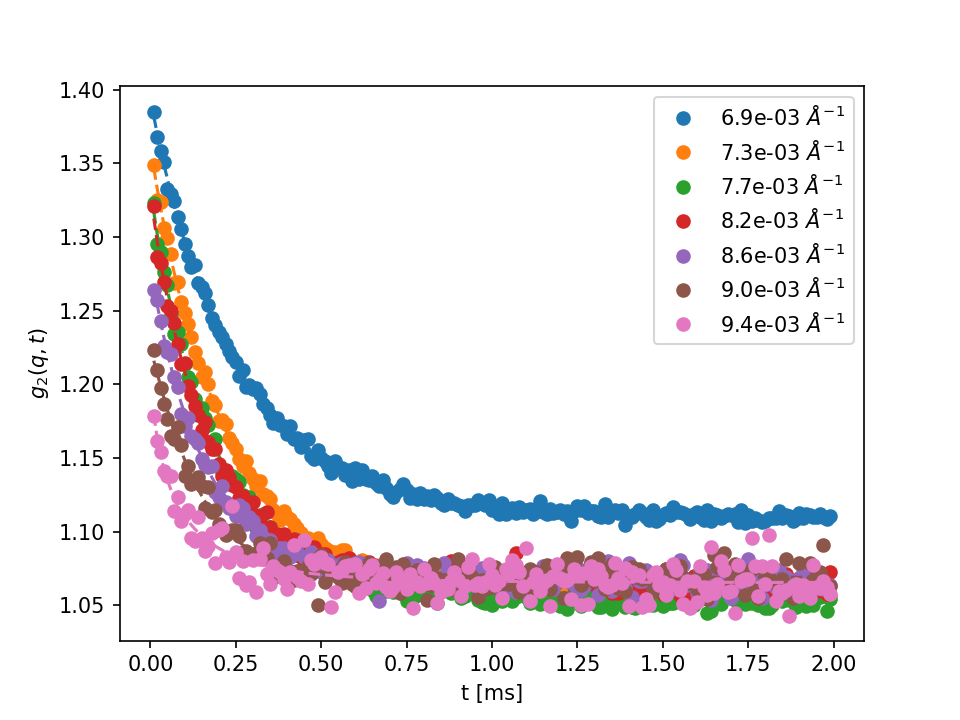

(199, 7)
0.2538836630608306
0.22335804849386853
0.19665375226239923
0.1736297980162702
0.1631909456213452
0.14133900310379333
0.10461474887617571


In [13]:
from scipy.special import gamma
from scipy.optimize import curve_fit

def exponential(x,a,b):
    return np.abs(a)*np.exp(-x/(np.abs(b)))+1

def stretched_exponential(x, a, b, c, baseline):
    return np.abs(a)*np.exp(-(x/np.abs(b))**c) + baseline

fit_func = stretched_exponential


plt.figure()
print(g2.shape)
decays = []
t = np.arange(1, 200)*exp_time * 1.0e3
for i in range(g2.shape[1]):
    l, = plt.plot(t, g2[:, i], 'o',  label=r'%.1e $\AA^{-1}$' %q[i])
    popt, pcov = curve_fit(fit_func, t, g2[:, i])#, p0=[0.35, 0.2, 1.0])
    plt.plot(t, fit_func(t, *popt), color=l.get_color(), linestyle='--')
    decay_time = popt[1] / popt[2] * gamma(1.0 / popt[2])
    print(abs(decay_time))
    decays.append(decay_time)

plt.xlabel('t [ms]')
plt.ylabel(r'$g_2 (q, t)$')
#plt.xscale('log')
plt.legend()
#plt.savefig('tristan.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


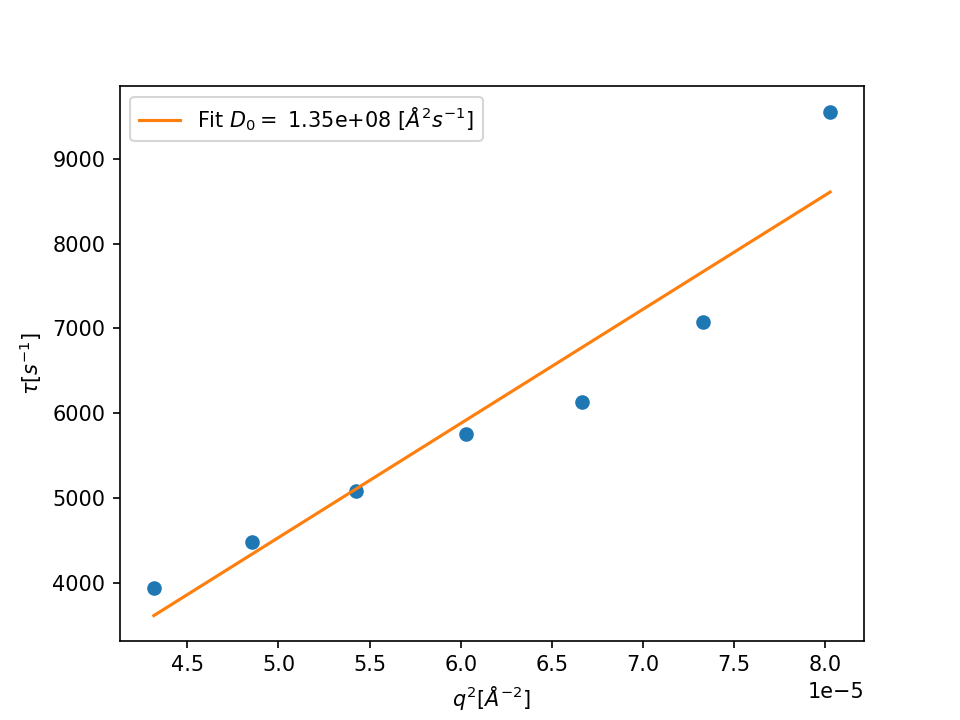

In [16]:
x = q**2
y = 1.0/np.abs(decays)*1.0e3
plt.figure()
plt.plot(x, y, 'o')
plt.xlabel(r'$q^2 [\AA^{-2}]$')
plt.ylabel(r'$\tau [s^{-1}]$')
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x, p(x), label=r'Fit $D_0 =$ %.2e $[\AA^2 s^{-1}]$' %p.c[0])
plt.legend(loc='upper left')
